## Introduction

In this example, we will build a multi-label text classifier to predict the subject areas of arXiv papers from their abstract bodies. This type of classifier can be useful for conference submission portals like [OpenReview](https://openreview.net/). Given a paper abstract, the portal could provide suggestions on which areas the underlying paper would best belong to.

The dataset was collected using the [`arXiv` Python library](https://github.com/lukasschwab/arxiv.py) that provides a wrapper around the [original arXiv API](http://arxiv.org/help/api/index). To know more, please refer to [this notebook](https://github.com/soumik12345/multi-label-text-classification/blob/master/arxiv_scrape.ipynb). 

## Imports

In [28]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ast import literal_eval
import pandas as pd
import numpy as np

## Read data and perform basic EDA

In this section, we first load the dataset into a `pandas` dataframe and then perform some basic exploratory data analysis (EDA).

In [ ]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()

,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


Our text features are present in the `summaries` column and their corresponding labels are in `terms`. As we can notice there are multiple categories associated with a particular entry. 

In [ ]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 51774 rows in the dataset.


Real-world data is noisy. One of the most commonly observed such noise is data duplication. Here we notice that our initial dataset has got about 13k duplicate entries. 

In [ ]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


Before proceeding further we first drop these entries. 

In [ ]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

There are 38972 rows in the deduplicated dataset.


In [ ]:
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

2321


In [ ]:
# How many unique terms?
print(arxiv_data["terms"].nunique())

3157


As observed above, out of 3157 unique combinations of `terms`, 2321 entries have the lowest occurrence. To prepare our train, validation, and test sets with [stratification](https://en.wikipedia.org/wiki/Stratified_sampling), we need to drop these terms. 

In [ ]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

## Convert the string labels to list of strings

The initial labels are represented as raw strings. Here we make them `List[str]` for a more compact representation. 

In [ ]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

## Stratified splits because of class imbalance

The dataset has a [class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset). So, to have a fair evaluation result, we need to ensure the datasets are sampled with stratification. To know more about different strategies to deal with the class imbalance problem, you can follow [this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data). For an end-to-end demonstration of classification with imbablanced data, refer to [Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).

In [ ]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Multi-label binarization

Now we preprocess our labels using [`MultiLabelBinarizer`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html). 

In [ ]:
mlb = MultiLabelBinarizer()
mlb.fit_transform(train_df["terms"])
mlb.classes_

array(['14J60 (Primary) 14F05, 14J26 (Secondary)', '62H30', '62H35',
       '62H99', '65D19', '68', '68Q32', '68T01', '68T05', '68T07',
       '68T10', '68T30', '68T45', '68T99', '68Txx', '68U01', '68U10',
       'E.5; E.4; E.2; H.1.1; F.1.1; F.1.3', 'F.2.2; I.2.7', 'G.3',
       'H.3.1; H.3.3; I.2.6; I.2.7', 'H.3.1; I.2.6; I.2.7', 'I.2',
       'I.2.0; I.2.6', 'I.2.1', 'I.2.10', 'I.2.10; I.2.6',
       'I.2.10; I.4.8', 'I.2.10; I.4.8; I.5.4', 'I.2.10; I.4; I.5',
       'I.2.10; I.5.1; I.4.8', 'I.2.1; J.3', 'I.2.6', 'I.2.6, I.5.4',
       'I.2.6; I.2.10', 'I.2.6; I.2.7', 'I.2.6; I.2.7; H.3.1; H.3.3',
       'I.2.6; I.2.8', 'I.2.6; I.2.9', 'I.2.6; I.5.1', 'I.2.6; I.5.4',
       'I.2.7', 'I.2.8', 'I.2; I.2.6; I.2.7', 'I.2; I.4; I.5', 'I.2; I.5',
       'I.2; J.2', 'I.4', 'I.4.0', 'I.4.3', 'I.4.4', 'I.4.5', 'I.4.6',
       'I.4.6; I.4.8', 'I.4.8', 'I.4.9', 'I.4.9; I.5.4', 'I.4; I.5',
       'I.5.4', 'K.3.2', 'astro-ph.IM', 'cond-mat.dis-nn',
       'cond-mat.mtrl-sci', 'cond-mat.soft', 'c

`MultiLabelBinarizer`separates out the individual unique classes available from the label pool and then uses this information to represent a given label set with 0's and 1's. Below is an example. 

In [ ]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = mlb.transform([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'cs.AI', 'stat.ML']
Label-binarized representation: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0]]


## Data preprocessing and `tf.data.Dataset` objects

We first get percentile estimates of the sequence lengths. The purpose will be clear in a moment.

In [ ]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.629650
std         41.521087
min          5.000000
25%        128.000000
50%        155.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

Notice that 50% of the abstracts have a length of 154 (you may get a different number based on the split). So, any number near that is a good enough approximate for the maximum sequence length. 

Now, we write utilities to prepare our datasets that would go straight to the text classifier model. 

In [ ]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"


def unify_text_length(text, label):
    # Split the given abstract and calculate its length.
    word_splits = tf.strings.split(text, sep=" ")
    sequence_length = tf.shape(word_splits)[0]
    
    # Calculate the padding amount.
    padding_amount = max_seqlen - sequence_length
    
    # Check if we need to pad or truncate.
    if padding_amount > 0:
        unified_text = tf.pad([text], [[0, padding_amount]], constant_values="<pad>")
        unified_text = tf.strings.reduce_join(unified_text, separator="")
    else:
        unified_text = tf.strings.reduce_join(word_splits[:max_seqlen], separator=" ")
    
    # The expansion is needed for subsequent vectorization.
    return tf.expand_dims(unified_text, -1), label


def make_dataset(dataframe, is_train=True):
    label_binarized = mlb.transform(dataframe["terms"].values)
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    dataset = dataset.map(unify_text_length).cache()
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Now we can prepare the `tf.data.Dataset` objects. 

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [ ]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {mlb.inverse_transform(label)[0]}")
    print(" ")

Abstract: b'A highly desirable property of a reinforcement learning (RL) agent -- and a\nmajor difficulty for deep RL approaches -- is the ability to generalize\npolicies learned on a few tasks over a high-dimensional observation space to\nsimilar tasks not seen during training. Many promising approaches to this\nchallenge consider RL as a process of training two functions simultaneously: a\ncomplex nonlinear encoder that maps high-dimensional observations to a latent\nrepresentation space, and a simple linear policy over this space. We posit that\na superior encoder for zero-shot generalization in RL can be trained by using\nsolely an auxiliary SSL objective if the training process encourages the\nencoder to map behaviorally similar observations to similar representations, as\nreward-based signal can cause overfitting in the encoder (Raileanu et al.,\n2021). We propose Cross-Trajectory Representation Learning (CTRL), a method\nthat runs within an RL agent and conditions its encoder to

## Vocabulary size for vectorization

Before we feed the data to our model we need to represent them as numbers. For that purpose, we will use the [`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization). It can operate as a part of your main model so that the model is excluded from the core preprocessing logic. This greatly reduces the chances of training and serving skew. 

We first calculate the number of unique words present in the abstracts.

In [ ]:
train_df["total_words"] = train_df["summaries"].str.split().str.len()
vocabulary_size = train_df["total_words"].max()
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Now we can create our text classifier model with the `TextVectorization` layer present inside it. 

## Create model with `TextVectorization`

A batch of raw text will first go through the `TextVectorization` layer and it will generate their integer representations. These will then be passed to the shallow model responsible for text classification. 

In [ ]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))


def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            # keras.Input(shape=(), dtype=tf.string),
            text_vectorizer,
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(len(mlb.classes_), activation="sigmoid"),
        ]
    )
    return shallow_mlp_model

Without the CPU placement, we run into: 

```
(1) Invalid argument: During Variant Host->Device Copy: non-DMA-copy attempted of tensor type: string
```

In [ ]:
shallow_mlp_model = make_model()
shallow_mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 498)               1         
_________________________________________________________________
dense (Dense)                (None, 512)               255488    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 152)               39064     
Total params: 425,881
Trainable params: 425,880
Non-trainable params: 1
_________________________________________________________________


## Train the model

We will train our model using the binary cross-entropy loss. This is because the labels are not disjoint. For a given abstract, we may have multiple categories. So, we will divide the prediction task into a series of multiple binary classification problems. This is also why we kept the activation function of the classification layer in our model to sigmoid. Researchers have used other combinations of loss function and activation function as well. For example, in [Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932), Mahajan et al. used the softmax activation function and cross-entropy loss to train their models. 

In [ ]:
epochs = 20

shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

Epoch 1/20
258/258 [==============================] - 4s 12ms/step - loss: 0.0778 - categorical_accuracy: 0.6148 - val_loss: 0.0227 - val_categorical_accuracy: 0.6519
Epoch 2/20
258/258 [==============================] - 3s 10ms/step - loss: 0.0229 - categorical_accuracy: 0.6810 - val_loss: 0.0215 - val_categorical_accuracy: 0.6759
Epoch 3/20
258/258 [==============================] - 3s 11ms/step - loss: 0.0218 - categorical_accuracy: 0.6855 - val_loss: 0.0207 - val_categorical_accuracy: 0.6830
Epoch 4/20
258/258 [==============================] - 3s 11ms/step - loss: 0.0209 - categorical_accuracy: 0.6904 - val_loss: 0.0205 - val_categorical_accuracy: 0.6994
Epoch 5/20
258/258 [==============================] - 3s 11ms/step - loss: 0.0203 - categorical_accuracy: 0.6934 - val_loss: 0.0200 - val_categorical_accuracy: 0.6945
Epoch 6/20
258/258 [==============================] - 3s 11ms/step - loss: 0.0197 - categorical_accuracy: 0.6949 - val_loss: 0.0198 - val_categorical_accuracy: 0.697

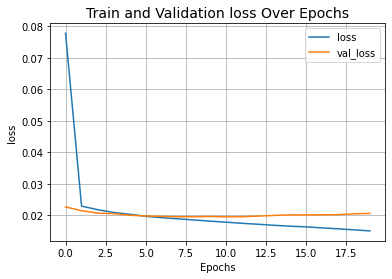

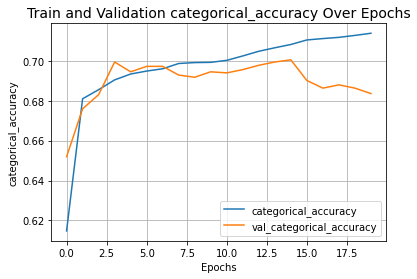

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

### Evaluate the model

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 0s 23ms/step - loss: 0.0200 - categorical_accuracy: 0.6978
Categorical accuracy on the test set: 69.78%.


While training, we notice an initial sharp fall in the loss followed by a gradual decay. The trained model gives us a validation accuracy of ~70%.

## Inference

In [68]:
text_batch, label_batch = next(iter(test_dataset))
predicted_probabilities = shallow_mlp_model(text_batch)

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text[0]}")
    print(f"Label(s): {mlb.inverse_transform(label)[0]}")
    predicted_proba = [float(proba.numpy()) for proba in predicted_probabilities[i]]
    top_3_labels = [x for _, x in sorted(zip(predicted_probabilities[i], mlb.classes_), key=lambda pair: pair[0], reverse=True)][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'Parametric causal modelling techniques rarely provide functionality for\ncounterfactual estimation, often at the expense of modelling complexity. Since\ncausal estimations depend on the family of functions used to model the data,\nsimplistic models could entail imprecise characterizations of the generative\nmechanism, and, consequently, unreliable results. This limits their\napplicability to real-life datasets, with non-linear relationships and high\ninteraction between variables. We propose Deep Causal Graphs, an abstract\nspecification of the required functionality for a neural network to model\ncausal distributions, and provide a model that satisfies this contract:\nNormalizing Causal Flows. We demonstrate its expressive power in modelling\ncomplex interactions and showcase applications of the method to machine\nlearning explainability and fairness, using true causal counterfactuals.<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad